In [7]:
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

import time

curr_directory = os.getcwd()

# Player Roster Information (Copied over from player_roster.ipynb)
teams = ['BOS','BRK','NYK','PHI','TOR','CHI','CLE','DET','IND','MIL','ATL','CHO','MIA','ORL','WAS',
         'DEN','MIN','OKC','POR','UTA','GSW','LAC','LAL','PHO','SAC','DAL','HOU','MEM','NOP','SAS']
        
# Dictionary of roster
# Ex. The roster of Boston Celtics players for the 2019-2020 season can be accessed using roster['BOS']['2019']
# It does not include any players/rookies for which there is no season data
roster = {}
    
for team in teams: 
    roster[team] = {}

# Initialize set for list of all players (with no repeats)
all_players = set()
    
for filename in os.listdir(os.path.join(curr_directory, 'data_sets/player_roster')):
    data = pd.read_csv(os.path.join('data_sets/player_roster', filename))
    year = filename[0:4]
    
    for team in teams:
        roster[team][year] = []
        
        players = data.loc[data['Tm'] == team]
        for ind in players.index: 
            player_name = players['Player'][ind].split('\\', 1)[0]
            if player_name not in roster[team][year]: 
                roster[team][year].append(player_name)
            
        all_players.update(roster[team][year])

num_players = len(all_players)
        
# Player dictionary that maps all players to index
player_index = dict(zip(list(all_players), range(len(all_players))))

game_data = pd.read_csv(os.path.join(curr_directory,'data_sets/nba.games.stats.csv'))

# Sort all values by the Date
game_data = game_data.sort_values(by=['Date'])

# game has chronical order and Y shows score differential, X plus is team 1 payer
# X minus is team 2 player
game_results = np.array(list(game_data['TeamPoints'] - game_data['OpponentPoints']))
teams = np.array(list(zip(game_data.Team, game_data.Opponent)))
dates = np.array(list(game_data['Date']))

unique_dates = list(set(dates))

# Makes an index of all games that are repeated
repeat_indexes = []

for date in unique_dates: 
    same_day = np.where(dates == date)
    # suppose same_day = [0, 1, 2, 3, 4, 5]
    for i in same_day[0]: 
        # start with i = 0
        for j in same_day[0]: 
            # j = 0, 1, 2, 3, 4, 5
            if j > i: 
                if np.array_equal(np.flip(teams[j], axis=0) , teams[i]): 
                    repeat_indexes.append(j)

# Make new unique game results, teams and dates arrays
unique_game_results = game_results[repeat_indexes]
unique_teams = teams[repeat_indexes]
unique_dates = dates[repeat_indexes]

In [2]:
class QuadraticRegression:
    def __init__(self, step_size=1e-5, max_iter=5000, eps=1e-4, theta=None, 
                  verbose=True):
        
        self.theta = theta
        self.step_size = step_size
        self.max_iter = max_iter
        self.eps = eps
        
    def getSAS(self):
        S = np.array(self.theta[0:962, 0:962])
        S2 = np.array(self.theta[963:1925, 963:1925])
        A = np.array(self.theta[0:962, 963:1925])
        A2 = np.array(self.theta[963:1925, 0:962])
        
        return S,S2,A,A2

    def predict(self, x): 
        z = x@self.theta@x.T 
        return self.sigmoid(z)
    
    def sigmoid(self, z): 
        return 1.0 / (1 + np.exp(-z))
    
    def gradBatchLossFunction(self, x_teams, y_teams):
        update = 0
        theta = np.matrix(self.theta)
        #S,S2,A,A2 = self.getSAS()
        
        for i in range(x_teams.shape[0]):
            x = np.matrix(x_teams[i, :])
            y = np.asscalar(y_teams[i])
            update += x.T@x@theta@x.T@x - y*x.T@x
        
        #add regularization terms
        #temp = np.zeros(self.theta.shape)
        #temp[0:962, 0:962] = S-S.T
        #temp[963:1925, 963:1925] = S2-S2.T
        #temp[0:962, 963:1925] = A+A.T
        #temp[963:1925, 0:962] = A2+A2.T
        #update += 1*temp
        #temp[0:962, 0:962] = S+S2
        #temp[963:1925, 963:1925] = S+S2
        #temp[0:962, 963:1925] = A+A2
        #temp[963:1925, 0:962] = A+A2
        #update += 1*temp
        
            
        return update
    
    def gradminiBatchLossFunction(self, x_teams, y_teams, batch_size, index):
        update = 0
        theta = np.matrix(self.theta)
        #S,S2,A,A2 = self.getSAS()
        
        for i in range(batch_size):
            x = np.matrix(x_teams[int((i+index) % x_teams.shape[0]), :])
            y = np.asscalar(y_teams[int((i+index) % x_teams.shape[0])])
            update += x.T@x@theta@x.T@x - y*x.T@x
            
        #add regularization terms-------------------------------    
        #temp = np.zeros(self.theta.shape)
        #temp[0:962, 0:962] = S-S.T
        #temp[963:1925, 963:1925] = S2-S2.T
        #temp[0:962, 963:1925] = A+A.T
        #temp[963:1925, 0:962] = A2+A2.T
        #update += 1*temp
        #temp[0:962, 0:962] = S+S2
        #temp[963:1925, 963:1925] = S+S2
        #temp[0:962, 963:1925] = A+A2
        #temp[963:1925, 0:962] = A+A2
        #update += 1*temp
            
        return update
    
    def fit(self, x, y, mini = False):
        iterations = 0
        abs_error = 1
        error_list = []
        batch_size = 32
        ind = 0
        
        if self.theta is None: 
            self.theta = np.zeros((2*num_players, 2*num_players))
        
        if mini == False:
            while iterations < self.max_iter and abs_error >= self.eps and abs_error < 1e6:
                error = self.step_size*self.gradBatchLossFunction(x, y)
                abs_error = np.linalg.norm(error, 2)
                error_list.append(abs_error)

                theta_new = self.theta - error
                #self.theta = theta_new
                self.theta = self.project(theta_new)

                iterations += 1

                print('Error {}: {}'.format(iterations, abs_error))
        else:
            while iterations < self.max_iter and abs_error >= self.eps and abs_error < 1e6:
                error = self.step_size*self.gradminiBatchLossFunction(x, y, batch_size, ind)
                abs_error = np.linalg.norm(error, 2)
                error_list.append(abs_error)

                theta_new = self.theta - error
                #self.theta = theta_new
                self.theta = self.project(theta_new)

                iterations += 1
                ind += batch_size

                print('Error {}: {}'.format(iterations, abs_error))
        
        print('Convergence!')
        plt.plot(error_list)
        plt.xlabel('Iterations')
        plt.ylabel('Error')
        plt.show()
        
    def process_data(self, teams, dates, results): 
        num_games = teams.shape[0]

        # Create x for all games
        # To access x for 0th game -- x[0, :] 
        x_without_intercept = np.zeros((num_games, 2*num_players))
        
        for i in range(num_games): 
            z, t = self.x_for_game(teams[i], dates[i])
            combined = np.vstack((z, t))
            x_without_intercept[i, :] = combined[:, 0]
            
        #x = self.add_intercept(x_without_intercept)
        x = x_without_intercept
        
        # Create y for all games (if team A wins, y = 1; if team B wins, y = 0)
        y = np.zeros((num_games, 1))
        for i in range(num_games): 
            if results[i] > 0: 
                y[i] = 1
            else:
                y[i] = 0
                
        return x, y

    def x_for_game(self, teams, date): 
        x_1 = np.zeros((num_players, 1))
        x_2 = np.zeros((num_players, 1))

        if int(date[5:7]) < 9: 
            year = str(int(date[0:4]) - 1)
        else: 
            year = date[0:4]

        team_1_players = roster[teams[0]][year]
        for item in team_1_players: 
            x_1[player_index[item]] = 1

        team_2_players = roster[teams[1]][year]
        for item in team_2_players: 
            x_2[player_index[item]] = 1

        return x_1, x_2
    
    def add_intercept(self, x): 
        new_x = np.zeros((x.shape[0], x.shape[1] + 1))
        new_x[:, 0] = 1
        new_x[:, 1:] = x
        
        return new_x
    
    def symmetrize(self, m):
        m = np.array(m)
        for i in range(m.shape[0]):
            for j in range(i, m.shape[1]):
                m[i][j] = m[j][i] = 0.5*(m[j][i] + m[i][j])
                
        return m
    
    def antisymmetrize(self, m):
        for i in range(m.shape[0]):
            for j in range(i, m.shape[1]):
                temp = m[i][j] - m[j][i]
                m[i][j] = 0.5*temp
                m[j][i] = -0.5*temp
                
        return m
    
    def project(self, m):
        m = np.array(m)
        side = m.shape[0]
        S = self.symmetrize(m[0:int(side/2 - 1),0:int(side/2 - 1)])
        S_minus = self.symmetrize(m[int(side/2):int(side-1), int(side/2):int(side-1)])

        A = self.antisymmetrize(m[0:int(side/2-1), int(side/2):int(side-1)])
        A_minus = self.antisymmetrize(m[int(side/2):int(side-1), 0:int(side/2-1)])
        S_new = (S - S_minus)/2
        S_minus_new = (S_minus - S)/2
        
        if np.allclose(A, -1*A_minus, 1e-10, 1e-10):
            A_new = A
            A_minus_new = A_minus
        elif np.linalg.norm(A.T - A_minus, 2) < np.linalg.norm(A - A_minus, 2):
            A_new = 0.5*(A + A_minus)
            A_minus_new = A_new.T
        else:
            A_new = 0.5*(A + A_minus.T)
            A_minus_new = A_new.T
            
        M = np.zeros(m.shape)
        M[0:int(side/2 - 1),0:int(side/2 - 1)] = S_new
        M[int(side/2):int(side-1),int(side/2):int(side - 1)] = S_minus_new
        M[0:int(side/2 - 1),int(side/2):int(side - 1)] = A_new
        M[int(side/2):int(side - 1),0:int(side/2 - 1)] = A_minus_new
        
        return M
    
    def general_predict(self, teams, dates, results): 
        test_x, test_y = self.process_data(teams, dates, results)
        
        predicted_y = []
        for i in range(test_x.shape[0]):
            x = test_x[i,:]
            
            x_new = x
            # x_new = np.reshape(x, (2*num_players, 1))
            prediction = self.predict(x_new)
            if np.asscalar(prediction) > 0.5: 
                predicted_y.append(1)
            else: 
                predicted_y.append(0)

        predicted_y = np.array(predicted_y)
        return np.mean(np.array(predicted_y) == np.array(test_y.T))
    
    def playoff_prediction(self, playoff_filename, playoff_date): 
        #Load playoff data
        playoff_data = pd.read_csv(os.path.join(curr_directory, playoff_filename))

        raw_playoff_results = np.array(list(playoff_data['PTS'] - playoff_data['PTS.1']))
        raw_playoff_team_pairs = np.array(list(zip(playoff_data['Visitor/Neutral'], playoff_data['Home/Neutral'])))
        raw_playoff_dates = np.array(list(playoff_data['Date']))

        playoff_pairs = {}

        for i in range(len(raw_playoff_team_pairs)): 
            team_1 = raw_playoff_team_pairs[i][0]
            team_2 = raw_playoff_team_pairs[i][1]
            if (team_1,team_2) in playoff_pairs.keys(): 
                # if results > 0 --> team A won --> +1
                # if results < 0 --> team B won --> -1
                if raw_playoff_results[i] > 0: 
                    playoff_pairs[team_1,team_2] += 1
                else: 
                    playoff_pairs[team_1,team_2] += -1
            elif (team_2,team_1) in playoff_pairs.keys():
                # if results > 0 --> team B won --> -1
                # if results < 0 --> team A won --> +1
                if raw_playoff_results[i] > 0: 
                    playoff_pairs[team_2,team_1] += -1
                else: 
                    playoff_pairs[team_2,team_1] += 1
            else: 
                if raw_playoff_results[i] > 0: 
                    playoff_pairs[team_1,team_2] = 1
                else: 
                    playoff_pairs[team_1,team_2] = -1

        playoff_teams = []
        playoff_results = []
        playoff_dates = []

        for key in playoff_pairs: 
            playoff_teams.append([key[0], key[1]])
            playoff_results.append(playoff_pairs[key])
            playoff_dates.append(playoff_date)

        playoff_teams = np.array(playoff_teams)
        playoff_results = np.array(playoff_results)
        playoff_dates = np.array(playoff_dates)

        playoff_x, playoff_y = self.process_data(playoff_teams, playoff_dates, playoff_results)

        predicted_y = []
        predictions = []

        for i in range(playoff_x.shape[0]):
            x = playoff_x[i,:]
            x_new = x
            # x_new = np.reshape(x, (2*num_players, 1))
            prediction = self.predict(x_new)
            predictions.append(prediction)
            if np.asscalar(prediction) > 0.5: 
                predicted_y.append(1)
            else: 
                predicted_y.append(0)

        predicted_y = np.array(predicted_y)

        prediction_accuracy = np.mean(np.array(predicted_y) == np.array(playoff_y.T[0][:]))

        return prediction_accuracy

Error 1: 0.008611804277997622
Error 2: 0.007767030031822521
Error 3: 0.007061497155279422
Error 4: 0.0064654301188944475
Error 5: 0.005956161830598412
Error 6: 0.0055162123758152725
Error 7: 0.005132041227208683
Error 8: 0.0047931673096537515
Error 9: 0.004491484208359802
Error 10: 0.004220710053837072
Error 11: 0.003975952924745696
Error 12: 0.003753377215935725
Error 13: 0.003549953749028738
Error 14: 0.0033632762990927325
Error 15: 0.0031914299554008686
Error 16: 0.0030329008091759236
Error 17: 0.002886521030016308
Error 18: 0.002751448421432847
Error 19: 0.00262718514506815
Error 20: 0.002513644596690416
Error 21: 0.00241126679796404
Error 22: 0.0023211193046876327
Error 23: 0.0022447299413740998
Error 24: 0.0021832311193752288
Error 25: 0.0021360747428000883
Convergence!


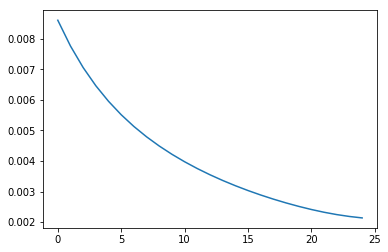

Time (s): 971.3841052055359


In [8]:
# 50 data points, shuffled, 1E-4 step size
test_2 = QuadraticRegression(step_size=1e-4, max_iter=25)
t_s, d_s, r_s = shuffle(unique_teams[0:100], unique_dates[0:100], unique_game_results[0:100], random_state=0)
x, y = test_2.process_data(t_s, d_s, r_s)

start = time.time()
test_2.fit(x, y, mini=False)
end = time.time()
print('Time (s): {}'.format(end-start))

In [9]:
dev_accuracy_test_2 = test_2.general_predict(t_s, d_s, r_s)
print(dev_accuracy_test_2)

0.76


In [ ]:
prediction_2014 = test_2.playoff_prediction('data_sets/2015_playoffs.csv', '2015-04-10')
print('Playoff Accuracy: {}'.format(prediction_2014))

In [ ]:
# Playoff Training for 2014-2015 Season
train_2014 = QuadraticRegression()

teams_14 = np.copy(unique_teams[0:1229])
dates_14 = np.copy(unique_dates[0:1229])
results_14 = np.copy(unique_game_results[0:1229])

teams_14, dates_14, results_14 = shuffle(teams_14, dates_14, results_14, random_state=0)
x_train_14, y_train_14 = train_2014.process_data(teams_14[0:983], dates_14[0:983], results_14[0:983])

train_2014.fit(x_train_14, y_train_14, mini=True)

dev_accuracy_14 = train_2014.general_predict(teams_14[984:1229], dates_14[984:1229], results_14[984:1229])
print('Dev Accuracy: {}'.format(dev_accuracy_14))

prediction_2014 = train_2014.playoff_prediction('data_sets/2015_playoffs.csv', '2015-04-10')
print('Playoff Accuracy: {}'.format(prediction_2014))

In [ ]:
# 50 data points, shuffled, 1E-5 step size
test = QuadraticRegression(max_iter=150)
t_s, d_s, r_s = shuffle(unique_teams[0:50], unique_dates[0:50], unique_game_results[0:50], random_state=0)
x, y = test.process_data(t_s, d_s, r_s)

test.fit(x, y, mini=True)

In [ ]:
# 50 data points, shuffled, 1E-4 step size
test_2 = QuadraticRegression(step_size=1e-4, max_iter=10)
t_s, d_s, r_s = shuffle(unique_teams[0:50], unique_dates[0:50], unique_game_results[0:50], random_state=0)
x, y = test_2.process_data(t_s, d_s, r_s)

test_2.fit(x, y, mini=True)

In [ ]:
dev_accuracy_test_2 = test_2.general_predict(t_s, d_s, r_s)

In [ ]:
# 50 data points, shuffled, 1E-3 step size
test_3 = QuadraticRegression(step_size=5e-4, max_iter=150)
t_s, d_s, r_s = shuffle(unique_teams[0:100], unique_dates[0:100], unique_game_results[0:100], random_state=0)
x, y = test_3.process_data(t_s, d_s, r_s)

test_3.fit(x, y, mini=True)

In [ ]:
# Plot results
fig, ax = plt.subplots()
S,S2,A,A2 = test.getSAS()

# Check for symmetry
print(np.allclose(S, S.T, 1e-10, 1e-10))
print(np.allclose(-1*S, S2, 1e-10, 1e-10))
print(np.allclose(-1*A, A.T, 1e-10, 1e-10))
print(np.allclose(A2.T, -1*A2, 1e-10, 1e-10))

# Plot matrix
im = ax.matshow(A)
cbar = fig.colorbar(im)

fig.tight_layout()
plt.show()

In [ ]:
# Load 2015 playoff data
playoff_data = pd.read_csv(os.path.join(curr_directory,'data_sets/2015_playoffs.csv'))

raw_playoff_results = np.array(list(playoff_data['PTS'] - playoff_data['PTS.1']))
raw_playoff_team_pairs = np.array(list(zip(playoff_data['Visitor/Neutral'], playoff_data['Home/Neutral'])))
raw_playoff_dates = np.array(list(playoff_data['Date']))

In [ ]:
playoff_pairs = {}

for i in range(len(raw_playoff_team_pairs)): 
    team_1 = raw_playoff_team_pairs[i][0]
    team_2 = raw_playoff_team_pairs[i][1]
    if (team_1,team_2) in playoff_pairs.keys(): 
        # if results > 0 --> team A won --> +1
        # if results < 0 --> team B won --> -1
        if raw_playoff_results[i] > 0: 
            playoff_pairs[team_1,team_2] += 1
        else: 
            playoff_pairs[team_1,team_2] += -1
    elif (team_2,team_1) in playoff_pairs.keys():
        # if results > 0 --> team B won --> -1
        # if results < 0 --> team A won --> +1
        if raw_playoff_results[i] > 0: 
            playoff_pairs[team_2,team_1] += -1
        else: 
            playoff_pairs[team_2,team_1] += 1
    else: 
        if raw_playoff_results[i] > 0: 
            playoff_pairs[team_1,team_2] = 1
        else: 
            playoff_pairs[team_1,team_2] = -1
            
print(playoff_pairs)

In [ ]:
playoff_teams = []
playoff_results = []
playoff_dates = []

for key in playoff_pairs: 
    playoff_teams.append([key[0], key[1]])
    playoff_results.append(playoff_pairs[key])
    playoff_dates.append('2015-04-10')
    
playoff_teams = np.array(playoff_teams)
playoff_results = np.array(playoff_results)
playoff_dates = np.array(playoff_dates)

    
playoff_x, playoff_y = test.process_data(playoff_teams, playoff_dates, playoff_results)

predicted_y = []
temp = playoff_x[0,:]
for i in range(playoff_x.shape[0]):
    x = playoff_x[i,:]    
    predicted_y.append(test.predict(x))

In [ ]:
prediction_accuracy = np.mean(np.array(predicted_y) == np.array(playoff_y.T[0][:]))
print(prediction_accuracy)
print(predicted_y)
print(np.array(predicted_y) == np.array(playoff_y.T[0][:]))

In [ ]:
test_x, test_y = test.process_data(unique_teams[2230:3000], unique_dates[2230:3000], unique_game_results[2230:3000])

In [ ]:
predicted_y = []
temp = test_x[0,:]
for i in range(test_x.shape[0]):
    x = test_x[i,:]    
    predicted_y.append(test.predict(x))
    
print(np.mean(np.array(predicted_y) == np.array(test_y.T)))